In [1]:
## Import relevant libraries
import sys
import os
import shutil
from natsort import natsorted  # For natural sorting
sys.path.append('../../activedrops')

## Including ourselves
import quadrop as qd
qd.set_plotting_style()

import glob
import imageio
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [3]:
data_path = "../../data/040624-K401_titration-30C/calibration/"

# let's declare the variable "conditions" to the sorted list of subdirectories from data_path
conditions = natsorted([f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))])[::-1]

# let's declare the variable "subconditions" to the sorted list of subdirectories from the first condition
subconditions = natsorted([f for f in os.listdir(os.path.join(data_path, conditions[0])) if os.path.isdir(os.path.join(data_path, conditions[0], f))])


# data_path = "../../data/040528-kif3-30C/calibration/"

# # let's declare the variable "conditions" to the sorted list of subdirectories from data_path
# conditions = natsorted([f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))])

# # let's declare the variable "subconditions" to the sorted list of subdirectories from the first condition
# subconditions = natsorted([f for f in os.listdir(os.path.join(data_path, conditions[0])) if os.path.isdir(os.path.join(data_path, conditions[0], f))])

subconditions

['Pos0']

In [4]:
qd.reorgTiffsToOriginal(data_path, conditions, subconditions)

Moved .tif files from ../../data/040624-K401_titration-30C/calibration/80ngul/Pos0 to ../../data/040624-K401_titration-30C/calibration/80ngul/Pos0/original
Moved .tif files from ../../data/040624-K401_titration-30C/calibration/40ngul/Pos0 to ../../data/040624-K401_titration-30C/calibration/40ngul/Pos0/original
Moved .tif files from ../../data/040624-K401_titration-30C/calibration/20ngul/Pos0 to ../../data/040624-K401_titration-30C/calibration/20ngul/Pos0/original
Moved .tif files from ../../data/040624-K401_titration-30C/calibration/10ngul/Pos0 to ../../data/040624-K401_titration-30C/calibration/10ngul/Pos0/original
Moved .tif files from ../../data/040624-K401_titration-30C/calibration/5ngul/Pos0 to ../../data/040624-K401_titration-30C/calibration/5ngul/Pos0/original
Moved .tif files from ../../data/040624-K401_titration-30C/calibration/2ngul/Pos0 to ../../data/040624-K401_titration-30C/calibration/2ngul/Pos0/original
Moved .tif files from ../../data/040624-K401_titration-30C/calibrati

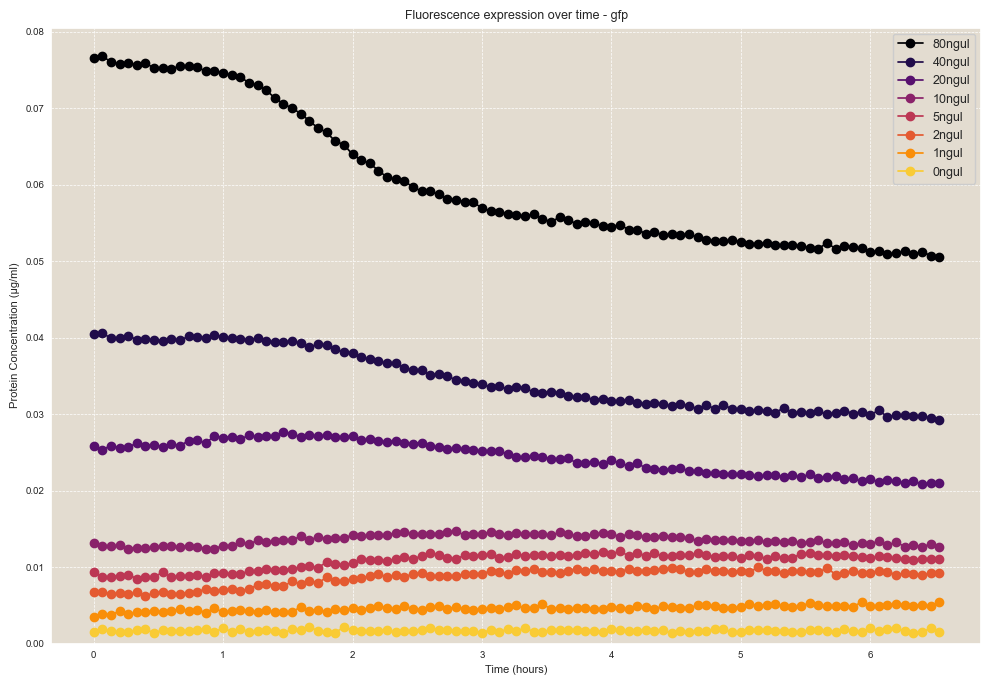

In [5]:
# channel info
channel = "gfp"
min_frame = 0
max_frame = None
skip_frames=4
frame_rate=30
time_intervals = [60] * len(conditions)

# Call the function with the updated parameters
qd.plot_fluorescence(
    data_path=data_path,
    conditions=conditions,
    subconditions=subconditions,
    channel=channel,
    time_intervals=time_intervals,  
    min_frame=min_frame,
    max_frame=max_frame,
    skip_frames=skip_frames,
    line_slope=1, 
    line_intercept=0,
    log_scale=False,  # Set log_scale to True
    timescale="h",
    averaged=True
)

In [6]:
def average_intensity_per_condition(data_path, conditions, subconditions, channel):
    """
    Computes and returns a table of the average of the average fluorescence intensity for each condition,
    with a separate column for concentration in µg/ml.

    Parameters:
    - data_path (str): Base path where the images are stored.
    - conditions (list of str): List of condition names.
    - subconditions (list of str): List of subcondition names.
    - channel (str): Channel name (e.g., "cy5", "gfp").
    
    Returns:
    - pd.DataFrame: DataFrame with columns ['concentration µg/ml', 'average_intensity'].
    """
    average_intensities = []
    
    for condition in conditions:
        # Parse out the numeric part of the condition and convert to an integer
        concentration = int(''.join(filter(str.isdigit, condition)))
        
        condition_intensities = []
        for subcondition in subconditions:
            directory_path = os.path.join(data_path, condition, subcondition, "original")
            
            if channel == "cy5":
                image_files = sorted(glob.glob(os.path.join(directory_path, "*cy5-4x_000.tif")))
            elif channel == "gfp":
                image_files = sorted(glob.glob(os.path.join(directory_path, "*gfp-4x_000.tif")))
            
            intensities = []
            
            for image_file in image_files:
                img = imageio.imread(image_file) / 2**16
                mean_intensity = np.mean(img[750:1250, 750:1250])
                intensities.append(mean_intensity)
            
            if intensities:  # Ensure there are intensities to average
                average_intensity = np.mean(intensities)
                condition_intensities.append(average_intensity)
        
        if condition_intensities:  # Ensure there are condition intensities to average
            condition_avg_intensity = np.mean(condition_intensities)
            average_intensities.append({
                "concentration µg/ml": concentration,
                "average_intensity": condition_avg_intensity
            })
    
    # Create DataFrame
    df = pd.DataFrame(average_intensities)
    # Sort by concentration just in case the input conditions were not in order
    df = df.sort_values(by="concentration µg/ml").reset_index(drop=True)

    df['average_intensity'] = df['average_intensity'] - df['average_intensity'][0]

    return df


df = average_intensity_per_condition(data_path, conditions[:], subconditions, channel)
df

/var/folders/_h/zqzyskvx2hd4w984syj7bb3m0000gn/T/ipykernel_28369/306109895.py:33: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_file) / 2**16


,concentration µg/ml,average_intensity
0,0,0.000000
1,1,0.003281
2,2,0.007237
3,5,0.009298
4,10,0.012219
5,20,0.022941
6,40,0.033095
7,80,0.059066


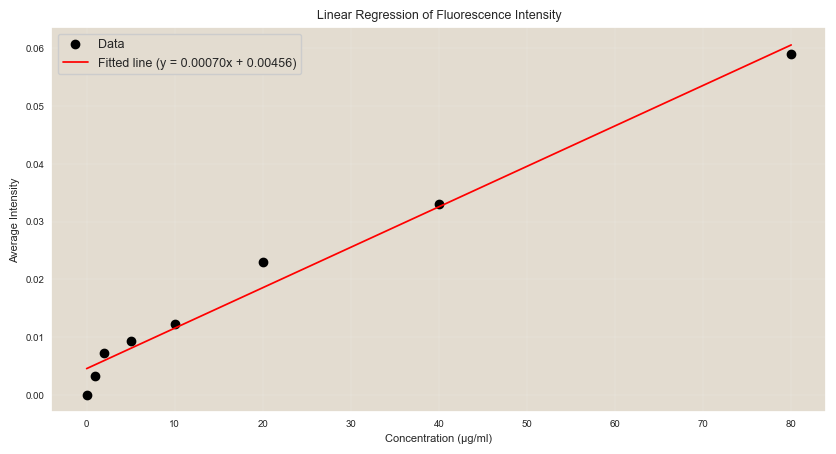

(0.0007003215799239484, 0.004560810221036941)

In [7]:
# Function to perform linear regression and plot the data along with the fitted line
def linear_regression_with_plot(df):
    # Reshape the data to fit sklearn's expected format
    X = df['concentration µg/ml'].values.reshape(-1, 1)
    y = df['average_intensity'].values
    
    # Create and fit the model
    model = LinearRegression().fit(X, y)
    
    # Coefficients
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Predicted values
    y_pred = model.predict(X)
    
    # Plotting the original data and the regression line
    plt.figure(figsize=(10, 5))
    plt.scatter(X, y, label='Data', color='black')
    plt.plot(X, y_pred, label=f'Fitted line (y = {slope:.5f}x + {intercept:.5f})', color='red')
    plt.title('Linear Regression of Fluorescence Intensity')
    plt.xlabel('Concentration (µg/ml)')
    plt.ylabel('Average Intensity')
    plt.legend()
    plt.show()
    
    return slope, intercept

# Assuming 'df' is the DataFrame provided earlier with concentration and average_intensity
slope, intercept = linear_regression_with_plot(df)

# Output the equation of the line
(slope, intercept)


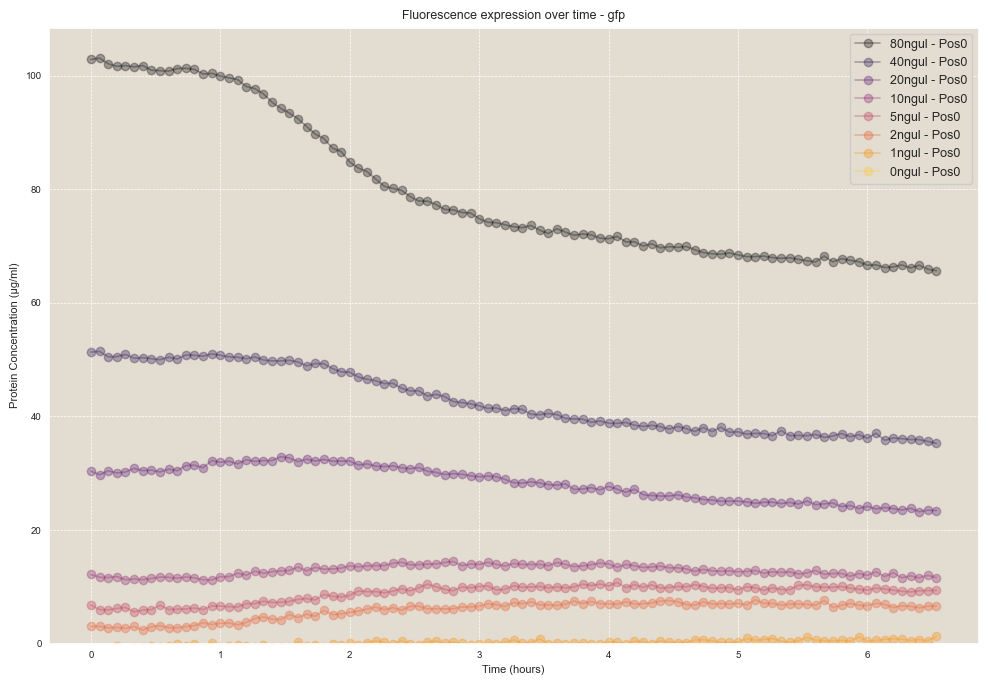

In [8]:
# channel info
channel = "gfp"
min_frame = 0
max_frame = None
skip_frames=4
frame_rate=30
time_intervals = [60] * len(conditions)

# Call the function with the updated parameters
qd.plot_fluorescence(
    data_path=data_path,
    conditions=conditions,
    subconditions=subconditions,
    channel=channel,
    time_intervals=time_intervals,  
    min_frame=min_frame,
    max_frame=max_frame,
    skip_frames=skip_frames,
    line_slope=slope, 
    line_intercept=intercept,
    log_scale=False,  # Set log_scale to True
    timescale="h",
    averaged=False
)

In [ ]:
# frame info
min_frame = 0
max_frame = None
skip_frames=8
frame_rate=30
time_intervals = [120] * len(conditions) 

# channel info 
channel = "gfp"
vmax = 50

qd.single_fluorescence_movies(data_path, conditions, subconditions, channel, time_intervals, min_frame, max_frame, vmax, skip_frames, frame_rate, line_slope=slope, line_intercept=intercept)

In [12]:
data_path = "../../data/040624-K401_titration-30C/pos0-7_standards-KVA_titration_2/"

# let's declare the variable "conditions" to the sorted list of subdirectories from data_path
conditions = natsorted([f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))])[::-1]

# let's declare the variable "subconditions" to the sorted list of subdirectories from the first condition
subconditions = natsorted([f for f in os.listdir(os.path.join(data_path, conditions[0])) if os.path.isdir(os.path.join(data_path, conditions[0], f))])

subconditions


['Pos0', 'Pos1', 'Pos2']

In [13]:
qd.reorgTiffsToOriginal(data_path, conditions, subconditions)

Moved .tif files from ../../data/040624-K401_titration-30C/pos0-7_standards-KVA_titration_2/80nM/Pos0 to ../../data/040624-K401_titration-30C/pos0-7_standards-KVA_titration_2/80nM/Pos0/original
Moved .tif files from ../../data/040624-K401_titration-30C/pos0-7_standards-KVA_titration_2/80nM/Pos1 to ../../data/040624-K401_titration-30C/pos0-7_standards-KVA_titration_2/80nM/Pos1/original
Moved .tif files from ../../data/040624-K401_titration-30C/pos0-7_standards-KVA_titration_2/80nM/Pos2 to ../../data/040624-K401_titration-30C/pos0-7_standards-KVA_titration_2/80nM/Pos2/original
Moved .tif files from ../../data/040624-K401_titration-30C/pos0-7_standards-KVA_titration_2/40nM/Pos0 to ../../data/040624-K401_titration-30C/pos0-7_standards-KVA_titration_2/40nM/Pos0/original
Moved .tif files from ../../data/040624-K401_titration-30C/pos0-7_standards-KVA_titration_2/40nM/Pos1 to ../../data/040624-K401_titration-30C/pos0-7_standards-KVA_titration_2/40nM/Pos1/original
Moved .tif files from ../../da

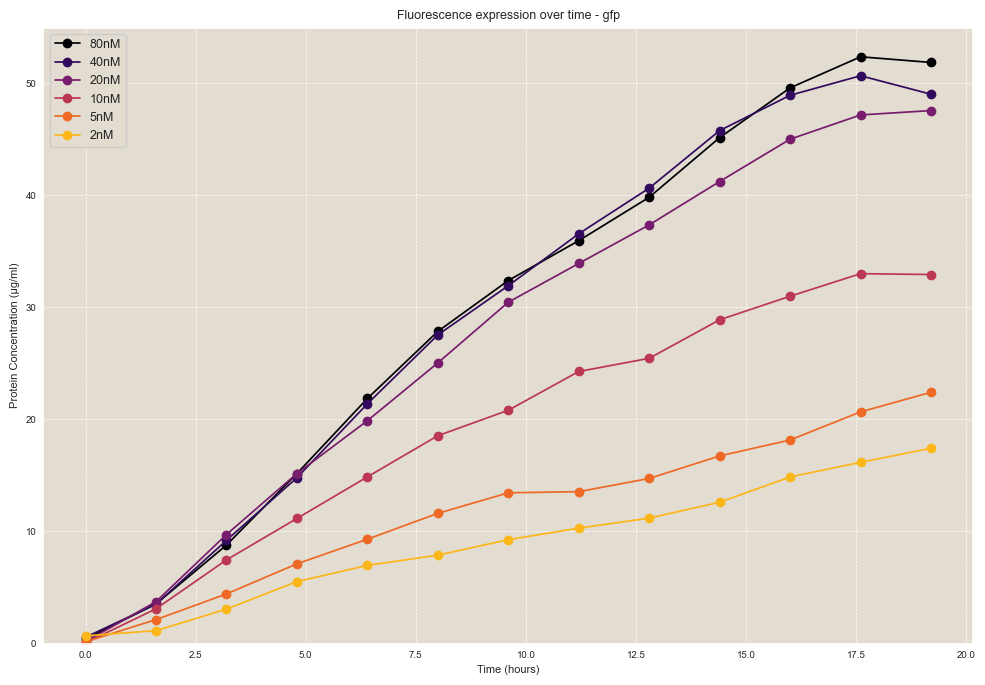

In [17]:
# channel info
channel = "gfp"
min_frame = 0
max_frame = None
skip_frames=32
frame_rate=30
time_intervals = [180] * len(conditions)

# Call the function with the updated parameters
qd.plot_fluorescence(
    data_path=data_path,
    conditions=conditions,
    subconditions=subconditions,
    channel=channel,
    time_intervals=time_intervals,  
    min_frame=min_frame,
    max_frame=max_frame,
    skip_frames=skip_frames,
    line_slope=0.00042, 
    line_intercept=0.00159,
    log_scale=False,  # Set log_scale to True
    timescale="h",
    averaged=True
)

In [ ]:
# frame info
min_frame = 0
max_frame = None
skip_frames=8
frame_rate=30
time_intervals = [120] * len(conditions) 

# channel info
channel = "cy5"
vmax = 0.4


qd.single_fluorescence_movies(data_path, conditions, subconditions, channel, time_intervals, min_frame, max_frame, vmax, skip_frames, frame_rate, )

In [ ]:
# frame info
min_frame = 0
max_frame = None
skip_frames=8
frame_rate=30
time_intervals = [120] * len(conditions) 

# channel info
channel = "gfp"
vmax = 20


qd.single_fluorescence_movies(data_path, conditions, subconditions, channel, time_intervals, min_frame, max_frame, vmax, skip_frames, frame_rate, line_slope=slope, line_intercept=intercept)